In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


In [3]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

# Function to show multiple images
def show_images(images, labels):
    fig = plt.figure()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title("Label: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
def get_noise(n_samples, noise_vector_dimension, device='cpu'):
    return torch.randn(n_samples, noise_vector_dimension, device=device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self,
                 image_dimension=784,
                 hidden_dimension=128):
        super().__init__()

        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        self.disc = nn.Sequential(
            self.discriminator_block(self.im_dim, 256),
            nn.Dropout(0.5),
            self.discriminator_block(256, 128),
            nn.Dropout(0.5),
            self.discriminator_block(128, 64),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.disc(image)

    def discriminator_block(self, in_dimension, out_dimension):
      return nn.Sequential(
           nn.Linear(in_dimension, out_dimension),
           nn.LeakyReLU(0.2, inplace=True)
      )

In [6]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=100,
                       image_dimension=784,
                       hidden_dimension=128):
        super().__init__()

        self.n_dim = noise_dimension
        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        # Generator network
        self.gen = nn.Sequential(
            self.generator_block(self.n_dim, 512),
            self.generator_block(512, 256),
            self.generator_block(256, self.h_dim),
            #self.generator_block(self.h_dim * 4, self.h_dim * 8),
            nn.Linear(self.h_dim, self.im_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.gen(noise)

    # Simple neural network single block
    def generator_block(self, in_dimension, out_dimension):
        return nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.BatchNorm1d(out_dimension),
            nn.LeakyReLU(0.2,inplace=True),
        )

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            fake_noise = get_noise(num_samples, self.n_dim, device=device)
            fake = self.forward(fake_noise)
        # Return the generated samples
        return fake

In [7]:
def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # All of them will got label as 0
    # .detach() here is to ensure that only discriminator parameters will get update
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred,
                               torch.zeros_like(disc_fake_pred))

    # Pass real features to discriminator
    # All of them will got label as 1
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred,
                               torch.ones_like(disc_real_pred))

    # Average of loss from both real and fake features
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # But all of them will got label as 1
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [8]:
display_step = 50
noise_dimension = 64

In [9]:
def train(disc, gen, batch_size=64, learning_rate=1e-5, num_epochs=150):

  # Define the loss function
  criterion = nn.BCEWithLogitsLoss()

  gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate)
  disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate)


  # Set the device to GPU if available, otherwise use CPU
  disc.to(device)
  gen.to(device)

  trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

  disc.train()
  gen.train()

  cur_step = 0
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False

  for epoch in range(num_epochs):
      for batch_idx, (real, labels) in enumerate (trainLoader):

          # Get number of batch size (number of image)
          # And get tensor for each image in batch
          cur_batch_size = len(real)
          real = real.view(cur_batch_size, -1).to(device)


          ### Traing discriminator ###
          # Zero out the gradient .zero_grad()
          # Calculate discriminator loss get_disc_loss()
          # Update gradient .gradient()
          # Update optimizer .step()
          disc_opt.zero_grad()
          disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
          disc_loss.backward(retain_graph=True)
          disc_opt.step()

          ### Traing generator ###
          # Zero out the gradient .zero_grad()
          # Calculate discriminator loss get_gen_loss()
          # Update gradient .gradient()
          # Update optimizer .step()
          gen_opt.zero_grad()
          gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
          gen_loss.backward()
          gen_opt.step()

          mean_discriminator_loss += disc_loss.item() / display_step
          mean_generator_loss += gen_loss.item() / display_step

          if cur_step % display_step == 0 and cur_step > 0:
              print(f"Epoch {cur_step/len(trainLoader)}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
              mean_generator_loss = 0
              mean_discriminator_loss = 0

          cur_step += 1

In [10]:
def show_images(images, labels):
    fig = plt.figure()
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i][0], cmap='gray')
        #plt.title("Original Truth Label: {}".format(labels[i].item()))
        plt.yticks([])
        plt.xticks([])
    plt.show()

def show_image(image, label):
    plt.imshow(image, cmap='gray')
    #plt.title("Original Truth Label: {}".format(label.item()))
    plt.yticks([])
    plt.xticks([])
    plt.show()

In [11]:
def sample_gan(generator, num_samples=1):
  generator.eval()
  
  decoded = generator.sample(num_samples).reshape(28,28).cpu()

  show_image(decoded, label=None)

In [12]:
gen = Generator(noise_dimension)
disc = Discriminator()

train(disc, gen,batch_size=100, learning_rate=1e-5, num_epochs=150)

Epoch 0.053304904051172705: Generator loss: 0.4778532058000565, discriminator loss: 0.7398561978340149
Epoch 0.10660980810234541: Generator loss: 0.47000151813030233, discriminator loss: 0.7204460430145263
Epoch 0.15991471215351813: Generator loss: 0.47150277614593494, discriminator loss: 0.7147057509422301
Epoch 0.21321961620469082: Generator loss: 0.47341948866844175, discriminator loss: 0.7071586847305298
Epoch 0.26652452025586354: Generator loss: 0.475249412059784, discriminator loss: 0.6978610730171203
Epoch 0.31982942430703626: Generator loss: 0.47701486229896545, discriminator loss: 0.68724245429039
Epoch 0.373134328358209: Generator loss: 0.4779428911209106, discriminator loss: 0.6781584870815276
Epoch 0.42643923240938164: Generator loss: 0.4779528546333313, discriminator loss: 0.6708072888851165
Epoch 0.47974413646055436: Generator loss: 0.4773926085233689, discriminator loss: 0.6663970172405242
Epoch 0.5330490405117271: Generator loss: 0.47576698899269104, discriminator loss:

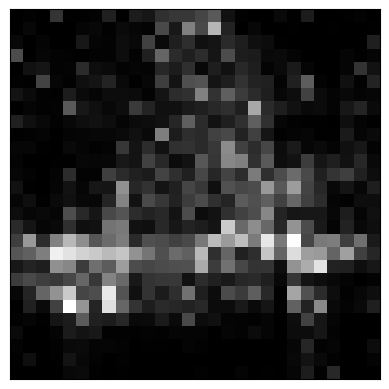

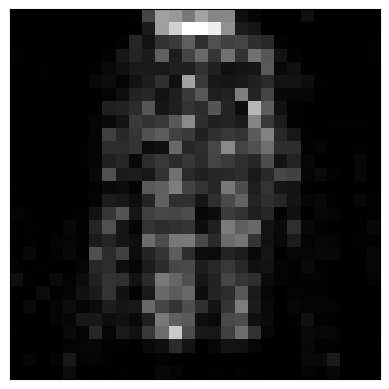

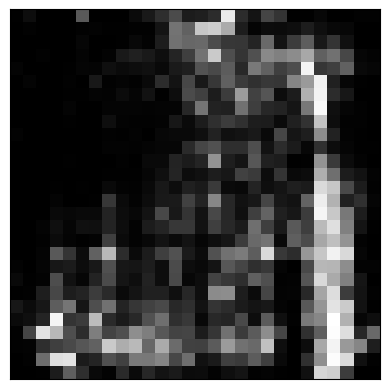

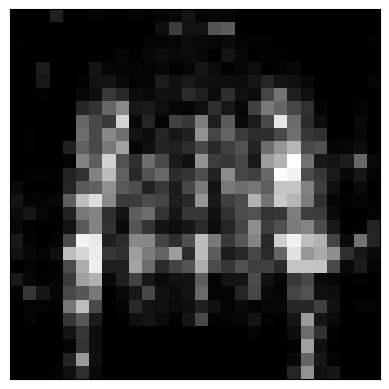

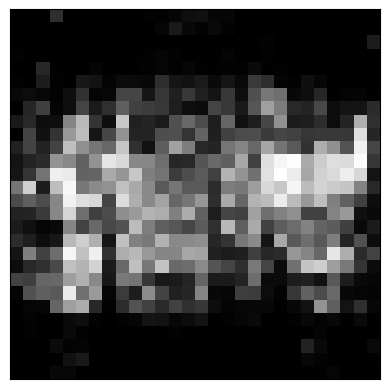

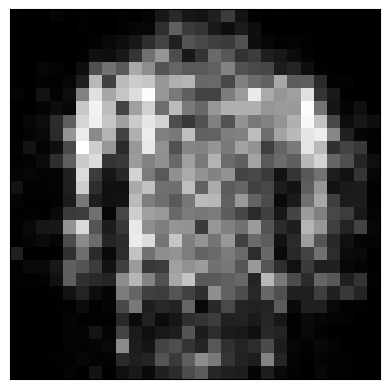

In [13]:
for i in range(6):
    sample_gan(gen.to(device), num_samples=1)

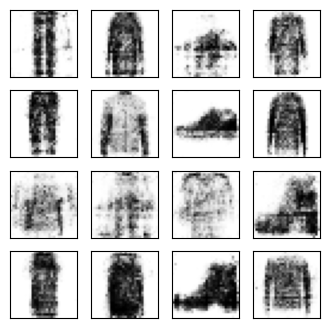

In [14]:
num_images=16
noise = torch.randn(num_images, noise_dimension, device=device)
with torch.no_grad():
    generated_images = gen(noise).cpu().numpy()
generated_images = np.reshape(generated_images, newshape=(-1, 28, 28))
fig, axes = plt.subplots(4, 4, figsize=(4, 4), sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), generated_images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img.squeeze(), cmap='gray_r')
plt.show()